For this first deliverable, I need to develop this:
<br /> 1.- Apply scaling techniques
<br /> 2.- preprocess of data

In [34]:
# All the imports come here
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Input, Conv2D, BatchNormalization, GlobalAveragePooling2D

In [ ]:
# It's important to comment the import depending on the OS
# Windows PC
base_dir = r"/dataset/car parts"

# Mac OS
# base_dir = "/Users/alanpagzz/Codes/carssification_AI/dataset/car parts"

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# drive_dataset_path = "/content/drive/MyDrive/Octavo Semestre/IA/proyecto/car dataset/car parts"

# New local route
# local_dataset_path = "/content/car_parts"

# Copy the dataset to the local machine (just once)
# if not os.path.exists(local_dataset_path):
#     shutil.copytree(drive_dataset_path, local_dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
train_dir = os.path.join(local_dataset_path , "train")
valid_dir = os.path.join(local_dataset_path , "valid")

# I will omit the test directory for now. I don't want to mix the test data with the training data

In [37]:
# Time to preprocess the data

# SCALING
# First, scale pixels. Refer te README for the preprocess_input value
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.2,
	  height_shift_range = 0.2,
    #shear_range = 0.3,
	  #zoom_range = 0.3,
	  horizontal_flip = True
    )

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.2,
	  height_shift_range = 0.2,
    #shear_range = 0.3,
	  #zoom_range = 0.3,
	  horizontal_flip = True
        )


# PREPROCESS
train_generator = train_datagen.flow_from_directory(
    train_dir,
    # My images are 254x254
    target_size=(254, 254),
    batch_size=8,
    class_mode="categorical",
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(254, 254),
    batch_size=8,
    class_mode="categorical",
    shuffle=False
)


Found 6917 images belonging to 40 classes.
Found 200 images belonging to 40 classes.


In [ ]:
# ResNet50
# Retrieved from documentation

with tf.device('/GPU:0'):
      ResNet50 = tf.keras.applications.ResNet50(
        input_shape=(254, 254, 3),
        include_top=False,
        weights="imagenet",
        classifier_activation="softmax",
        name="resnet50"
      )

      ResNet50.trainable = False

  # This is my model
      model = tf.keras.models.Sequential([
        ResNet50,
        GlobalAveragePooling2D(),
        Dense(512, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(40, activation = 'softmax')
  ])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,707,624 (94.25 MB)

 Trainable params: 1,119,912 (4.27 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Time to add a checkpoint

# I want it on the same spot on every device, It's easier

# Drive
# checkpoint_path = "/content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/cp-{epoch:02d}.keras"

# Windows
checkpoint_path = os.path.join(r"./", "checkpoints", "cp-{epoch:02d}.keras")

# Mac OS
# checkpoint_path = PUTSOMETHINGHERE

# Callback to save the best model
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Callback to stop if tehre's no improvement in 3 epochs
earlystop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [40]:
def compile_model_simple(newModel):
    # CATEGORICAL CROSS SENTROPY
    newModel.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics=['accuracy'])

def train_model_simple(newModel, scaled_train_images):
  # The cancer model paper mentions that it reaches a good level of accuracy on
  # epoch 20ish (The graph is up to epoch 25)
    history = newModel.fit(scaled_train_images,
                        validation_data=valid_generator,
                        epochs = 5,
                        callbacks=[checkpoint_cb, earlystop_cb])
    return history

In [41]:
compile_model_simple(model)
history = train_model_simple(model, train_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5464 - loss: 1.6784
Epoch 1: val_accuracy improved from -inf to 0.83000, saving model to /content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/cp-01.weights.h5


865/865 ━━━━━━━━━━━━━━━━━━━━ 139s 148ms/step - accuracy: 0.5466 - loss: 1.6777 - val_accuracy: 0.8300 - val_loss: 0.6068
Epoch 2/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8676 - loss: 0.4287
Epoch 2: val_accuracy did not improve from 0.83000
865/865 ━━━━━━━━━━━━━━━━━━━━ 121s 140ms/step - accuracy: 0.8676 - loss: 0.4288 - val_accuracy: 0.8150 - val_loss: 0.6689
Epoch 3/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9079 - loss: 0.2909
Epoch 3: val_accuracy improved from 0.83000 to 0.87000, saving model to /content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/cp-03.weights.h5


865/865 ━━━━━━━━━━━━━━━━━━━━ 121s 140ms/step - accuracy: 0.9078 - loss: 0.2909 - val_accuracy: 0.8700 - val_loss: 0.5384
Epoch 4/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9282 - loss: 0.2279
Epoch 4: val_accuracy improved from 0.87000 to 0.87500, saving model to /content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/cp-04.weights.h5


865/865 ━━━━━━━━━━━━━━━━━━━━ 122s 141ms/step - accuracy: 0.9281 - loss: 0.2279 - val_accuracy: 0.8750 - val_loss: 0.4633
Epoch 5/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9396 - loss: 0.1964
Epoch 5: val_accuracy did not improve from 0.87500
865/865 ━━━━━━━━━━━━━━━━━━━━ 120s 139ms/step - accuracy: 0.9396 - loss: 0.1964 - val_accuracy: 0.8700 - val_loss: 0.5954
Restoring model weights from the end of the best epoch: 4.


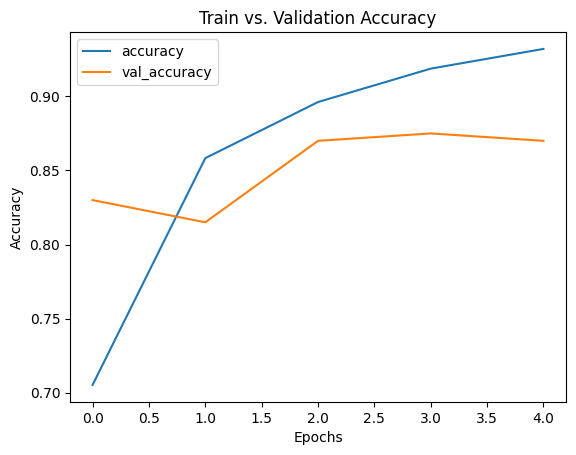

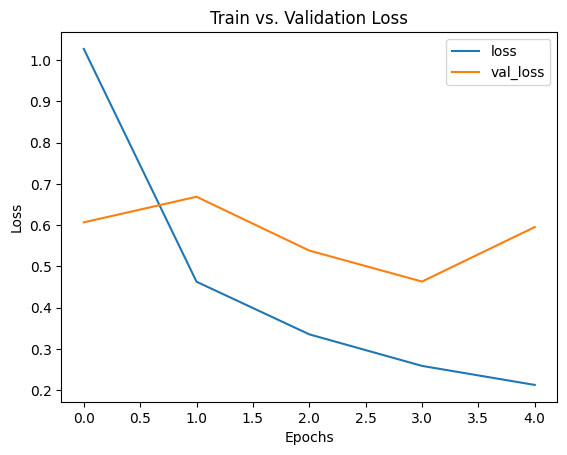

In [42]:
frame = pd.DataFrame(history.history)
acc_plot = frame.plot(y=["accuracy", "val_accuracy"], title="Train vs. Validation Accuracy", legend=True)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")
plt.show()

loss_plot = frame.plot(y=["loss", "val_loss"], title="Train vs. Validation Loss", legend=True)
loss_plot.set(xlabel="Epochs", ylabel="Loss")
plt.show()

In [43]:
# Get true classes and predicted classes for the validation set
true_classes = valid_generator.classes

# Predict probabilities for the validation set
valid_generator.reset()
val_pred_probs = model.predict(valid_generator, verbose=1)
val_pred_classes = np.argmax(val_pred_probs, axis=1)

precision = precision_score(true_classes, val_pred_classes, average='macro')
recall = recall_score(true_classes, val_pred_classes, average='macro')
f1 = f1_score(true_classes, val_pred_classes, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step
Precision: 0.8949
Recall: 0.8750
F1 Score: 0.8728
